# Collect ICU Stay and Caregiver Data

## NOTE: This is the first notebook of a 3 notebook series. 

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np

#Util
import itertools
import datetime

# Database libraries
import psycopg2

# Stats libraries
from tableone import TableOne
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

# Image libraries
# https://jakevdp.github.io/pdvega/
# jupyter nbextension enable vega3 --py --sys-prefix
import matplotlib.pyplot as plt
import pdvega 
%matplotlib inline

C:\Users\Reunion\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Create a database connection
# Replace user and password with credentials
user = 'xxx'
password = 'xxx'
host = 'hst953.csail.mit.edu'
dbname = 'mimic'
schema = 'mimiciii'

In [3]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=password)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

## Querying the Data

Here we query the database and extract information about a specific ICU stay. To increase performance we subset the data by age range.

In [4]:
# Run query and assign the results to a Pandas DataFrame
# Requires the icustay_detail view from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics
# And the OASIS score from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores
query = \
"""
WITH first_icu AS (
    SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admittime admittime_hospital, 
      i.dischtime dischtime_hospital, i.los_hospital, i.age, i.admission_type, 
      i.hospital_expire_flag, i.intime intime_icu, i.outtime outtime_icu, i.los_icu, i.hospstay_seq, i.icustay_seq,
      s.first_careunit,s.last_careunit,s.first_wardid, s.last_wardid
    FROM icustay_detail i
    LEFT JOIN icustays s
    ON i.icustay_id = s.icustay_id
    WHERE i.age > 50 AND i.age <= 60
)
SELECT f.*, o.icustay_expire_flag, o.oasis, o.oasis_prob
FROM first_icu f
LEFT JOIN oasis o
ON f.icustay_id = o.icustay_id;
"""

data = pd.read_sql_query(query,con)

After the data is loaded, we can take a look at it

In [5]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'hospstay_seq', 'icustay_seq', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'icustay_expire_flag', 'oasis',
       'oasis_prob'],
      dtype='object')

In [6]:
data

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,age,admission_type,hospital_expire_flag,...,los_icu,hospstay_seq,icustay_seq,first_careunit,last_careunit,first_wardid,last_wardid,icustay_expire_flag,oasis,oasis_prob
0,292,179726,222505,F,2103-09-27 18:28:00,2103-09-28 15:44:00,0.8861,57.0273,URGENT,1,...,0.8854,1,1,MICU,MICU,12,12,1,48,0.486353
1,323,128132,206073,M,2119-09-21 20:34:00,2119-10-06 18:50:00,14.9278,56.7428,EMERGENCY,0,...,11.9999,2,1,MICU,MICU,12,12,0,31,0.097783
2,324,146127,285067,M,2199-10-16 01:11:00,2199-10-16 17:19:00,0.6722,54.9774,EMERGENCY,0,...,0.6528,1,1,TSICU,TSICU,33,33,0,25,0.048012
3,344,176203,238865,F,2154-11-12 20:53:00,2154-11-16 05:45:00,3.3694,58.1857,EMERGENCY,1,...,3.4836,1,1,MICU,MICU,15,15,1,23,0.037612
4,353,159730,265453,M,2148-06-15 11:04:00,2148-07-04 17:48:00,19.2806,58.8965,URGENT,0,...,2.1264,1,1,CSRU,CSRU,14,14,0,38,0.209226
5,354,131861,227646,M,2189-02-12 18:29:00,2189-03-02 14:09:00,17.8194,59.4558,EMERGENCY,0,...,6.4636,1,1,CCU,CSRU,57,14,0,37,0.188911
6,73,194730,284305,F,2170-12-22 00:12:00,2170-12-26 12:00:00,4.4917,57.5865,EMERGENCY,0,...,2.6794,1,1,CCU,CCU,57,57,0,22,0.033259
7,125,157348,268261,F,2179-02-14 21:23:00,2179-02-21 18:03:00,6.8611,50.9632,ELECTIVE,0,...,1.2281,1,1,CSRU,CSRU,15,15,0,36,0.170145
8,132,160192,267893,F,2115-05-06 21:53:00,2115-05-25 12:10:00,18.5951,56.2063,EMERGENCY,0,...,15.8681,1,1,SICU,SICU,23,23,0,31,0.097783
9,138,188284,254974,M,2133-12-21 23:52:00,2134-01-11 13:00:00,20.5472,50.1640,EMERGENCY,0,...,3.9687,2,1,SICU,SICU,57,57,0,25,0.048012


We are interested in all of the rows related to a certain subject. We could do this with a database query, but to save network overhead we will do this here in memory

In [7]:
subj_rows = []
for i,subj_id in enumerate(data['subject_id']):
    if subj_id == 13033:
        subj_rows.append(i)

Some subjects have multiple ICU stays, we would like to analyze the last stay because if the patient dies within a stay it will be their last. 

In [8]:
#This tuple is row, value
m_icu_id = (0,0)

#We want to find the last ICU stay so we find the maximum
for row_i in subj_rows:
    d = data['icustay_seq'][row_i]
    if d > m_icu_id[1]:
        m_icu_id = (row_i,d)
        
m_icu_id

(0, 0)

One off code is great and all, but we would prefer to create maintainable code that can later be extracted from the notebook, so the above code is merged into a function which creates a dictionary. This dictionary contains all of the tuples we generate keyed by subject

In [1]:
def create_icu_table():
    icu_table = {}
    sub_m = {}
    #Find the rows related to each subject
    for i,subj_id in enumerate(data['subject_id']):    
        if subj_id not in sub_m:
            sub_m[subj_id] = []
        sub_m[subj_id].append(i)
    
    # For each row across the subject we find the last ICU stay
    for subj,subj_rows in sub_m.items():
        for row_i in subj_rows:
            d = data['icustay_seq'][row_i]
            if d > icu_table.get(subj,(0,0))[1]:
                icu_table[subj]=(row_i,d)
                
    return icu_table

In [10]:
it = create_icu_table()

Now that we have all the relavant rows, we can subset our initial data set

In [11]:
target_rows = []
for row_i, _ in it.values():
    target_rows.append(row_i)

In [12]:
data.iloc[target_rows]

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,age,admission_type,hospital_expire_flag,...,los_icu,hospstay_seq,icustay_seq,first_careunit,last_careunit,first_wardid,last_wardid,icustay_expire_flag,oasis,oasis_prob
0,292,179726,222505,F,2103-09-27 18:28:00,2103-09-28 15:44:00,0.8861,57.0273,URGENT,1,...,0.8854,1,1,MICU,MICU,12,12,1,48,0.486353
1,323,128132,206073,M,2119-09-21 20:34:00,2119-10-06 18:50:00,14.9278,56.7428,EMERGENCY,0,...,11.9999,2,1,MICU,MICU,12,12,0,31,0.097783
2,324,146127,285067,M,2199-10-16 01:11:00,2199-10-16 17:19:00,0.6722,54.9774,EMERGENCY,0,...,0.6528,1,1,TSICU,TSICU,33,33,0,25,0.048012
3,344,176203,238865,F,2154-11-12 20:53:00,2154-11-16 05:45:00,3.3694,58.1857,EMERGENCY,1,...,3.4836,1,1,MICU,MICU,15,15,1,23,0.037612
4,353,159730,265453,M,2148-06-15 11:04:00,2148-07-04 17:48:00,19.2806,58.8965,URGENT,0,...,2.1264,1,1,CSRU,CSRU,14,14,0,38,0.209226
5,354,131861,227646,M,2189-02-12 18:29:00,2189-03-02 14:09:00,17.8194,59.4558,EMERGENCY,0,...,6.4636,1,1,CCU,CSRU,57,14,0,37,0.188911
6,73,194730,284305,F,2170-12-22 00:12:00,2170-12-26 12:00:00,4.4917,57.5865,EMERGENCY,0,...,2.6794,1,1,CCU,CCU,57,57,0,22,0.033259
7,125,157348,268261,F,2179-02-14 21:23:00,2179-02-21 18:03:00,6.8611,50.9632,ELECTIVE,0,...,1.2281,1,1,CSRU,CSRU,15,15,0,36,0.170145
8,132,160192,267893,F,2115-05-06 21:53:00,2115-05-25 12:10:00,18.5951,56.2063,EMERGENCY,0,...,15.8681,1,1,SICU,SICU,23,23,0,31,0.097783
9,138,188284,254974,M,2133-12-21 23:52:00,2134-01-11 13:00:00,20.5472,50.1640,EMERGENCY,0,...,3.9687,2,1,SICU,SICU,57,57,0,25,0.048012


Just to be safe, we check that the table length is the same as the unique subjects

In [13]:
len(data['subject_id'].unique())

6827

In [14]:
#optional write out to spreadsheet

#writer = pd.ExcelWriter('max_icu_stay.xlsx')
#data.iloc[target_rows].to_excel(writer,'Sheet1')
#writer.save()

## Getting caregiver data

Test a query against the database for the caregivers associated with a specific chart

In [15]:
item = 228232
query = \
"""
    SELECT c.subject_id, c.hadm_id, c.icustay_id, c.charttime,
    c.cgid,g.label   
    FROM chartevents c
    LEFT JOIN caregivers g
    ON c.cgid = g.cgid
    WHERE c.icustay_id = """+str(item)+"""
"""

data_cg = pd.read_sql_query(query,con)

We see here that there a multiple caregivers which monitored this paitent; however, we do not know the role of each caregiver

In [16]:
data_cg['cgid'].value_counts()

18765    1160
15443     672
14418     637
15816     552
19947     442
17461     340
14427     285
15331     174
16047      26
21570      23
16284      20
14077      12
17485       2
21347       2
20389       1
Name: cgid, dtype: int64

To find the caregiver label we check another row

In [17]:
def get_cgid_label(df, cgid):
    return df.loc[df['cgid'] == cgid]['label'].values[0]

In [ ]:
#test functionality
get_cgid_label(data_cg,18765)

List comprehensions are always 100% easy to understand :P

This list comprehension finds the associated label for each caregiver

In [19]:
[get_cgid_label(data_cg,idxx) for idxx in data_cg['cgid'].value_counts().index]

['MD',
 'RN',
 'RN',
 'RN',
 'RN',
 'RN',
 'RN',
 None,
 'RN',
 None,
 'RN',
 None,
 'RN',
 'PCT',
 'RRT']

Our previous query was a little too broad. Let's try looking at just some common labels

In [20]:
query = \
"""
    SELECT g.label   
    FROM caregivers g
    WHERE g.label = 'RN' OR g.label = 'MD' OR g.label = 'Res' OR g.label = 'RO' OR g.label = 'MDs'
"""

data_cglabel = pd.read_sql_query(query,con)

In [21]:
data_cglabel['label'].value_counts()

RO     1658
MD     1380
Res    1238
RN     1185
MDs     226
Name: label, dtype: int64

Functions are useful, and in this case we would like to quickly count the number of labels from each group given a certain ICU stay

In [22]:
def get_measure_info(subj_icustay_id):
    
    #Check type for safety
    if type(subj_icustay_id)!= int:
        raise TypeError
    
    #TODO: Params for query
    query = \
    """
        SELECT c.icustay_id,c.cgid,g.label   
        FROM chartevents c
        LEFT JOIN caregivers g
        ON c.cgid = g.cgid
        WHERE c.icustay_id = """+str(subj_icustay_id)+"""
    """

    data_cg = pd.read_sql_query(query,con)
    
    
    #The same list comprehension we saw above
    mea_list = [(get_cgid_label(data_cg,idxx),v) for idxx, v in data_cg['cgid'].value_counts().items()]
    
    #clinic_types -> ['RO','MD','Res','RN','MDs']
    counts = {"RO":[0,0],"MDs":[0,0],"RN":[0,0],"OTH":[0,0]}
    
    # We will count the total measurements
    total_meas = 0
    
    # Iterate over the measurements and count for each label group
    for m_inst, m_visit_count in mea_list:
        
        total_meas = total_meas + m_visit_count
        
        if (m_inst == None):
            counts["OTH"][0] = counts["OTH"][0] + 1
            counts["OTH"][1] = counts["OTH"][1] + m_visit_count

        else:
            cmp = m_inst.upper()
            if (cmp == "RO"):
                counts["RO"][0] = counts["RO"][0] + 1
                counts["RO"][1] = counts["RO"][1] + m_visit_count
            elif (cmp == "MDS"):
                counts["MDs"][0] = counts["MDs"][0] + 1
                counts["MDs"][1] = counts["MDs"][1] + m_visit_count
            elif (cmp == "MD"):
                counts["MDs"][0] = counts["MDs"][0] + 1
                counts["MDs"][1] = counts["MDs"][1] + m_visit_count
            elif (cmp == "RES"):
                counts["MDs"][0] = counts["MDs"][0] + 1
                counts["MDs"][1] = counts["MDs"][1] + m_visit_count
            elif (cmp == "RN"):
                counts["RN"][0] = counts["RN"][0] + 1
                counts["RN"][1] = counts["RN"][1] + m_visit_count
            else:
                counts["OTH"][0] = counts["OTH"][0] + 1
                counts["OTH"][1] = counts["OTH"][1] + m_visit_count
    
    # Returns a dictionary and int
    return (counts,total_meas)

In [23]:
get_measure_info(228232)

({'MDs': [1, 1160], 'OTH': [5, 212], 'RN': [9, 2976], 'RO': [0, 0]}, 4348)

In [24]:
#subset data to only the rows that contain the last visit
data_mro = data.iloc[target_rows]

Produce measurement info for every row in the dataset. We slice to keep the queries small and the internet in the conference space was not great and caused large network delays

In [26]:
data_slices = []
cur_b = 0
width = 29
while cur_b < len(data_mro):   
    s = datetime.datetime.now()
    d_info = data_mro['icustay_id'][cur_b:cur_b + width].apply(get_measure_info)
    data_slices.append(d_info)
    e = datetime.datetime.now()
    print((e-s).total_seconds(),cur_b)
    cur_b = cur_b + width + 1

53.705785 0
55.211939 30
32.282709 60
26.199493 90
22.368535 120
57.2578 150
23.543367 180
33.549172 210
20.999469 240
21.605512 270
64.971425 300
24.042831 330
24.569112 360
40.597861 390
48.524337 420
21.894411 450
37.269272 480
37.035039 510
14.526358 540
17.150319 570
16.56757 600
16.919891 630
17.075295 660
14.578178 690
21.655764 720
11.294809 750
14.247302 780
15.426437 810
13.920371 840
10.480809 870
14.870679 900
13.143025 930
11.476448 960
10.273903 990
16.752023 1020
17.77665 1050
25.383812 1080
24.817493 1110
24.082382 1140
18.589211 1170
20.591512 1200
23.452483 1230
19.021744 1260
28.232313 1290
19.624372 1320
20.680749 1350
13.986589 1380
25.620091 1410
28.935049 1440
18.582744 1470
25.588256 1500
19.689983 1530
38.417763 1560
24.420909 1590
12.82255 1620
27.279436 1650
14.400629 1680
16.961761 1710
17.511662 1740
10.553067 1770
9.615342 1800
13.530902 1830
17.321627 1860
11.427612 1890
9.911787 1920
15.89594 1950
19.539467 1980
16.467793 2010
15.7625 2040
15.05874 2070


In [37]:
data_slices

[0       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [3, 756],...
 1       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [17, 1588...
 2       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [2, 247],...
 3       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [9, 3811]...
 4       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [1, 580],...
 5       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [5, 4807]...
 6       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [3, 540],...
 7       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [5, 2000]...
 8       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [20, 1070...
 9       ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [10, 6356...
 10      ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [4, 1331]...
 11      ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [8, 5078]...
 12      ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [13, 6738...
 4634    ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [61, 6951...
 14      ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [9, 1698]...
 15      ({'RO': [0, 0], 'MDs': [0, 0], 'RN': [2, 1413]...
 19      ({'RO': [0, 0], 'MDs': [1, 3], 'RN': [10, 8125.

We can look at the age distribution with a histogram

(array([622., 612., 639., 649., 652., 687., 681., 734., 776., 775.]),
 array([50.0015, 51.0012, 52.0009, 53.0006, 54.0003, 55.    , 55.9997,
        56.9994, 57.9991, 58.9988, 59.9985]),
 <a list of 10 Patch objects>)

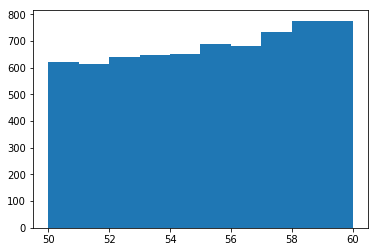

In [29]:
plt.hist(data_mro['age'])

## Save the data

In [30]:
pickle.dump(data_slices,open("d_slices_5060_g.p", "wb" ))

In [31]:
pickle.dump(data_mro,open("d_mro_5060_g.p","wb"))